In [1]:
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.spatial.distance import cdist

from collections import Counter

plt.style.use("dark_background")

In [2]:
data = pd.read_csv("../KNNAlgorithmDataset.csv")
data

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,NaN
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,NaN
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,NaN
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,NaN


In [ ]:
data["diagnosis"].replace({"B": 0, "M": 1}, inplace=True)
data.drop(columns=['Unnamed: 32', 'id'], inplace=True)

In [4]:
X = data.drop(columns=["diagnosis"]).to_numpy()
y = data["diagnosis"].to_numpy()

In [5]:
def gaussian_kernel(distance, h):
    """
    Гауссово ядро для окна Парзена
    distance: расстояние до соседей
    h: ширина окна
    """
    return np.exp(-((distance / h) ** 2) / 2) / (np.sqrt(2 * np.pi) * h)

In [6]:
class KNNParzen:
    def __init__(self, k=5, h=1.0, kernel=gaussian_kernel):
        """
        Инициализирует модель KNN с ядром Парзена.

        Параметры:
            k (int): Число ближайших соседей. По умолчанию 5.
            h (float): Параметр сглаживания ядра. По умолчанию 1.0.
            kernel (callable): Функция ядра. По умолчанию gaussian_kernel.
        """
        self.k = k
        self.h = h
        self.kernel = kernel

    def fit(self, X, y):

        self.X_train = np.array(X)
        self.y_train = np.array(y)

    def predict(self, X_test):

        X_test = np.array(X_test)
        if len(X_test.shape) == 1:
            X_test = X_test.reshape(1, -1)

        # вычисляем евклидовы расстояния между тестовыми и тренировочными точками
        distances = np.sqrt(
            np.sum(X_test ** 2, axis=1).reshape(-1, 1)
            + np.sum(self.X_train ** 2, axis=1).reshape(1, -1)
            - 2 * np.dot(X_test, self.X_train.T)
        )

        # сортируем расстояния и индексы
        sorted_distances_idx = np.argsort(distances, axis=1)
        sorted_distances = np.sort(distances, axis=1)
        k_neighbors_idx = sorted_distances_idx[:, :self.k]  # индексы k ближайших соседей
        k_distances = sorted_distances[:, :self.k]  # расстояния до k ближайших соседей

        k_max_neib = k_distances[:, -1].reshape(-1, 1)  # максимальное расстояние до k-го соседа
        kernel_weights = self.kernel(k_distances, k_max_neib)  # вычисляем веса ядра

        labels = self.y_train[k_neighbors_idx]  # метки k ближайших соседей
        classes = np.unique(self.y_train)  # уникальные классы

        weighted_votes = np.zeros((X_test.shape[0], len(classes)))  # матрица взвешенных голосов
        for idx, cls in enumerate(classes):
            cls_mask = (labels == cls)  # маска для текущего класса
            weighted_votes[:, idx] = np.sum(kernel_weights * cls_mask, axis=1)  # сумма взвешенных голосов для текущего класса

        return classes[np.argmax(weighted_votes, axis=1)]  # возвращаем класс с максимальной суммой взвешенных голосов

In [10]:
def LOO(X, y, k_neib, h):
    """
    Выполняет оценку методом оставления одного (Leave-One-Out) для модели KNN с ядром Парзена.

    Параметры:
        X (array-like): Матрица признаков.
        y (array-like): Вектор меток.
        k_neib (list): Список значений k для оценки.
        h (float): Параметр сглаживания ядра.

    Возвращает:
        best_k (int): Лучшее значение k.
        metrics (numpy.ndarray): Массив метрик ошибок для каждого значения k.
    """

    metrics = np.zeros(len(k_neib))  # массив для хранения метрик ошибок

    for index, k in enumerate(k_neib):
        for i in range(len(y)):
            # извлекаем тестовую точку и метку
            x_test = X.iloc[i].to_numpy() if hasattr(X, 'iloc') else X[i]
            y_test = y.iloc[i] if hasattr(y, 'iloc') else y[i]

            # извлекаем тренировочные данные, исключая тестовую точку
            X_train = X.drop(i) if hasattr(X, 'drop') else np.delete(X, i, axis=0)
            y_train = y.drop(i) if hasattr(y, 'drop') else np.delete(y, i)

            # обучаем модель KNN с ядром Парзена
            knn = KNNParzen(k=k, h=h)
            knn.fit(X_train, y_train)

            # предсказываем метку для тестовой точки
            y_pred = knn.predict(x_test)

            # обновляем метрику ошибки
            if y_pred[0] == y_test:
                metrics[index] += 1

        # вычисляем среднюю ошибку для текущего значения k
        metrics[index] = 1 - metrics[index] / len(y)

    # возвращаем лучшее значение k и массив метрик ошибок
    return k_neib[np.argmin(metrics)], metrics.flatten()

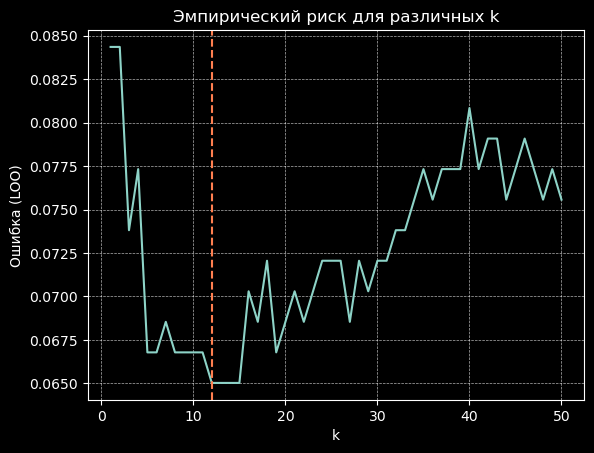

In [18]:
k_values = range(1, 51)
h = 1.0
k_best, errors = LOO(X, y, k_values, h)

plt.plot(k_values, errors, linestyle='-')
plt.title("Эмпирический риск для различных k")
plt.xlabel("k")
plt.ylabel("Ошибка (LOO)")
plt.axvline(k_best, color='#ff7f50', linestyle='--')

plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.savefig('../assets/graph.png')
plt.show()

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

def compare_knn(X_train, y_train, X_test, y_test, k, h):
    start = time.time()
    knn_parzen = KNNParzen(k=k, h=h)
    knn_parzen.fit(X_train, y_train)
    y_pred_custom = knn_parzen.predict(X_test)
    end = time.time()
    custom_time = end - start

    start = time.time()
    knn_lib = KNeighborsClassifier(n_neighbors=k)
    knn_lib.fit(X_train, y_train)
    y_pred_lib = knn_lib.predict(X_test)
    end = time.time()
    lib_time = end - start

    metrics = {
        "Accuracy": (accuracy_score(y_test, y_pred_custom), accuracy_score(y_test, y_pred_lib)),
        "Precision": (precision_score(y_test, y_pred_custom), precision_score(y_test, y_pred_lib)),
        "Recall": (recall_score(y_test, y_pred_custom), recall_score(y_test, y_pred_lib)),
        "F1-Score": (f1_score(y_test, y_pred_custom), f1_score(y_test, y_pred_lib)),
        "Time (sec)": (custom_time, lib_time),
    }
    return metrics

In [16]:
metrics = compare_knn(X_train, y_train, X_test, y_test, k_best, h=1.0)
print("Metrics (Custom KNN | Library KNN):")
for metric, values in metrics.items():
    print(f"{metric}: {values[0]:.4f} | {values[1]:.4f}")

Metrics (Custom KNN | Library KNN):
Accuracy: 0.9386 | 0.9298
Precision: 1.0000 | 1.0000
Recall: 0.8333 | 0.8095
F1-Score: 0.9091 | 0.8947
Time (sec): 0.0364 | 0.0826
